In [76]:
import random
import librosa
import librosa.display
from scipy.ndimage import zoom
# import scipy
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf


# import torch
# import torchaudio
# from torchaudio import transforms
%matplotlib inline

In [137]:
def fourier_db(stft):
    fourier_abs = np.abs(stft)
    dB = 20 * np.log10(fourier_abs / np.max(fourier_abs))
    return dB

# Create psychoacoustically relevant frequency filters
def freq_filters(cents_interval: int) -> list:
    f0 = 27.5
    cents = range(0,11500,cents_interval) # Until 19KHz 300 cents = minor 3rd filters
    fil_freq = np.round([f0*(pow((2**((1.0/1200))),i)) for i in cents])
    return fil_freq

import numpy as np
import librosa

def noise_in_freq_range(stft: np.ndarray, low_freq: float, high_freq: float, noise_level_dB: float, band_pass: bool = False) -> np.ndarray:
    """
    Apply noise to a specific frequency range of a Short-Time Fourier Transform (STFT).

    Parameters:
    -----------
    stft : numpy.ndarray
        The input STFT of the audio signal.

    low_freq : float
        The lower bound of the frequency range (in Hz) to which noise will be applied.

    high_freq : float
        The upper bound of the frequency range (in Hz) to which noise will be applied.

    noise_level_dB : float
        The noise level in decibels (dB). This value determines the amplitude of the noise added.

    band_pass : bool, optional, default: False
        If True, the noise will replace the values in the specified frequency range, acting as a band-pass filter.
        If False, the noise will be added to the existing values in the specified frequency range.

    Returns:
    --------
    numpy.ndarray
        The time-domain audio signal with noise added to the specified frequency range.

    Description:
    ------------
    The `noise_in_freq_range` function adds or replaces noise in a specific frequency range of an audio signal's STFT.
    The noise level is specified in decibels and converted to a linear scale for processing. The function allows for
    two modes of operation:
    - Additive noise: Noise is added to the existing values in the specified frequency range.
    - Band-pass noise: Noise replaces the existing values in the specified frequency range, effectively acting as a
      band-pass filter.
    """
    stft_mag, stft_phase = librosa.magphase(stft)
    
    # Find the indices of the frequency bins that lie within the desired range
    fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0])
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)

    # Apply noise to the magnitude of the specified frequency bins
    noise = np.random.randn(*stft_mag.shape) * noise_level_linear

    if band_pass == False:
        # Add noise to the original values
        stft_mag[freq_bins, :] += noise[freq_bins, :]
    else:
        # Replace the values with noise, acting as a band-pass filter
        stft_mag[freq_bins, :] = noise[freq_bins, :]

    # Combine the modified magnitude with the original phase
    D_noisy = stft_mag * stft_phase

    # Perform the inverse STFT to convert back to the time domain
    audio_noise = librosa.istft(D_noisy)

    return audio_noise


def time_displacement(signal: np.ndarray, noise: bool = False) -> np.ndarray:
    """
    Apply a random time shift to the input signal with optional noise padding.

    Parameters:
    -----------
    signal : numpy.ndarray
        The input audio signal to be time-shifted.
        
    noise : bool, optional, default: False
        If True, pads the shifted signal with random noise. If False, pads the shifted signal with zeros.

    Returns:
    --------
    numpy.ndarray
        The time-shifted audio signal, with the same length as the input signal.

    Description:
    ------------
    The `time_stretch` function applies a random time shift to the input audio signal. The shift is randomly chosen
    within one-third of the length of the input signal in both directions (positive and negative). Depending on the
    `noise` parameter, the padding for the time-shifted signal can either be random noise or zeros.

    The function performs the following steps:
    1. Generate a random shift value (`start_`) within the range [-len(signal)/3, len(signal)/3].
    2. Depending on the `noise` parameter:
       - If `noise` is True, the signal is padded with random noise within the range [-0.01, 0.01].
       - If `noise` is False, the signal is padded with zeros.
    3. The shifted and padded signal is then returned, truncated to the length of the input signal.

    Examples:
    ---------
    >>> import numpy as np
    >>> signal = np.random.randn(1000)
    >>> shifted_signal = time_stretch(signal, noise=True)
    >>> print(shifted_signal.shape)
    (1000,)
    """
    start_ = int(np.random.uniform(-len(signal) / 3, len(signal) / 3))
    print('Time shift:', start_)
    
    if start_ >= 0:
        if noise:
            padding = np.random.uniform(-0.01, 0.01, start_)
        else:
            padding = np.zeros(start_)
        ts = np.concatenate((signal[start_:], padding), axis=0)
    else:
        if noise:
            padding = np.random.uniform(-0.01, 0.01, -start_)
        else:
            padding = np.zeros(-start_)
        ts = np.concatenate((padding, signal[:start_]), axis=0)
    
    # Ensure the output has the same length as the input
    ts = ts[:len(signal)]
    return ts

def time_stretch_with_padding(signal, speed_range=(0.7, 1.3), noise_level=0.001):
    """
    Apply time stretching to the input signal with optional noise padding to match the original length.

    Parameters:
    -----------
    signal: numpy.ndarray
        The input audio signal to be time-stretched.

    speed_range: tuple of float, optional, default: (0.7, 1.3)
        The range (min, max) of the speed rate for stretching. Lower value means faster playback, higher means slower.

    noise_level: float, optional, default: 0.001
        The range for the uniform noise used for padding. Noise will be in the range [-noise_level, noise_level].

    Returns:
    --------
    numpy.ndarray
        The time-stretched and padded (if necessary) audio signal, with the same length as the input signal.
    """

    # Initialize random number generator
    rng = np.random.default_rng()

    # Generate a random speed rate within the given range
    speed_rate = rng.uniform(low=speed_range[0], high=speed_range[1])

    # Perform time stretching by resampling
    stretched_signal = zoom(signal, speed_rate)

    # Calculate padding lengths
    original_len = len(signal)
    stretched_len = len(stretched_signal)
    pad_len = max(0, original_len - stretched_len)
    cut_len = max(0, stretched_len - original_len)

    # Generate padding noise
    if pad_len > 0:
        noise = rng.uniform(-noise_level, noise_level, size=pad_len)
        pad_before = noise[: int(pad_len / 2)]
        pad_after = noise[int(pad_len / 2) :]
    else:
        pad_before = np.empty(0)
        pad_after = np.empty(0)

    # Adjust the length of the output to match the original length
    if stretched_len < original_len:
        stretched_signal = np.concatenate((pad_before, stretched_signal, pad_after))
    else:
        start_index = int(cut_len / 2)
        stretched_signal = stretched_signal[start_index : start_index + original_len]

    return stretched_signal

import numpy as np
import librosa

def mix_up(signal, patch, noise_level_dB, low_freq, high_freq, sr=22050, n_fft=1024, mono=False):
    """
    Apply a patch from a patch audio file to the original STFT in a specific frequency range with a given noise level.

    Parameters:
    -----------
    stft : numpy.ndarray
        The STFT of the original audio signal.
        
    patch : str
        Path to the patch audio file to be applied.
        
    noise_level_dB : float
        The noise level in decibels (dB) to be applied to the patch.
        
    low_freq : float
        The lower bound of the frequency range (in Hz) to which the patch will be applied.
        
    high_freq : float
        The upper bound of the frequency range (in Hz) to which the patch will be applied.
        
    sr : int, optional, default: 22050
        The sampling rate for loading the audio files.
        
    n_fft : int, optional, default: 1024
        The number of FFT components.
        
    duration : float, optional, default: 5
        The duration (in seconds) to load from the patch audio file.
        
    mono : bool, optional, default: False
        If True, the patch audio file will be converted to mono.

    Returns:
    --------
    numpy.ndarray
        The time-domain audio signal with the patch applied to the specified frequency range.
    """
    # Load the audio file
    audio_file, sr = librosa.load(signal, mono=mono, sr=sr)
    
    # Load the patch file
    patch_file, sr = librosa.load(patch, mono=mono, sr=sr)
    
    if len(patch_file) > len(audio_file):
        patch_file = patch_file[:len(audio_file)]
    
    elif len(patch_file) < len(audio_file):
        zeros = np.zeros_like((len(audio_file)-len(patch_file)))
        patch_file = np.concatenate(patch_file[:len(audio_file)], zeros)
    
    audio_stft = librosa.stft(audio_file, n_fft=n_fft)
    patch_stft = librosa.stft(patch_file, n_fft=n_fft)
    
    # Compute magnitude and phase for the patch and original STFT
    stft_mag_patch, stft_phase_patch = librosa.magphase(patch_stft)
    stft_mag_orig, stft_phase_orig = librosa.magphase(audio_stft)

    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)
    patch_db = stft_mag_patch * noise_level_linear

    # Find the indices of the frequency bins that lie within the desired range
    fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

    # Apply the patch to the original STFT magnitude
    stft_mag_orig[freq_bins, :] += patch_db[freq_bins, :]

    # Reconstruct the STFT with the original phase
    mix_up = stft_mag_orig * stft_phase_orig

    # Perform the inverse STFT to convert back to the time domain
    mix_up_audio = librosa.istft(mix_up)

    return mix_up_audio


def plot_spectrogam(hop_length, file):
    plt.figure(figsize=(8, 4))
    D = librosa.amplitude_to_db (np.abs (librosa.stft (file, hop_length=hop_length)),
                                 ref=np.max)
    librosa.display.specshow (D, y_axis='log', sr=sr, hop_length=hop_length,
                              x_axis='time')
    plt.title ('Log-frequency power spectrogram')
    
def plot_mel_spectrogam(file, title):
    plt.figure(figsize=(8, 4))
    S = librosa.feature.melspectrogram(y=file, sr=sr, n_mels=128,
                                    fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,
                             fmax=11025, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=title)

def plot_fourier(signal, fft_freqs, title, fill_area=None, fill=False):
    plt.figure(figsize=(8, 4))
    plt.plot(fft_freqs[:300], signal.T[10][:300])
    
    if fill and fill_area is not None:
        # Fill the gray area
        plt.fill_between(fill_area, plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.5)
        if fill_area[0] > 1000:
            plt.xlim(fill_area[0]-1000, fill_area[1]+1000)
        else:
            plt.xlim(fill_area[0]-500, fill_area[1]+500)
    
    plt.xticks(fill_area)
    plt.ylim(-80,0)
    # plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title(title)
    plt.show()
    plt.close()

def plot_compare(original_audio, modified_audio):
    plt.figure (figsize=(8, 6))
    plt.subplot (2, 1, 1)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (original_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Original Spectrogram')
    plt.colorbar (format='%+2.0f dB')
    plt.subplot (2, 1, 2)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (modified_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Noisy Spectrogram')
    plt.colorbar (format='%+2.0f dB')
    plt.tight_layout ()
    plt.show ()

In [134]:
# Load file and perform STFT
redhot = fr"C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav"
title = redhot.split('''\\''')[-1]
redhot_file, sr = librosa.load(redhot, duration=5, mono=False, sr=22050)

n_fft = 1024
stft = librosa.stft(redhot_file, n_fft=n_fft)
fft_freqs = np.round(librosa.fft_frequencies(sr=sr, n_fft=n_fft))

# play file
# ipd.Audio(redhot_file, rate=sr)
# plot_spectrogam(hop_length=1024, file=redhot_file)
# plot_mel_spectrogam(file=redhot_file, title=title)

print(len(redhot_file))

110250


In [124]:
# time displacement - introduces noise/silence to change the start/end point of file keeping its length
wav_time_shift = time_displacement(redhot_file, noise=True)
ipd.Audio(wav_time_shift, rate=sr)
# plot_spectrogam(hop_length=1024, file=wav_time_shift)

Time shift: -8321


In [125]:
# changing the speed rate and the pitch (proportionally)
random_time_shifting = time_stretch_with_padding(redhot_file)
ipd.Audio(random_time_shifting, rate=sr)

In [126]:
# changing length without changing pitch (time stretch)
time_stretch = librosa.effects.time_stretch(y=redhot_file, rate=1.2)
ipd.Audio(time_stretch, rate=sr)

In [128]:
# create psychoacoustic fitlers
filters = freq_filters(cents_interval=100)
# print(filters)

Filtering from 300 to 900


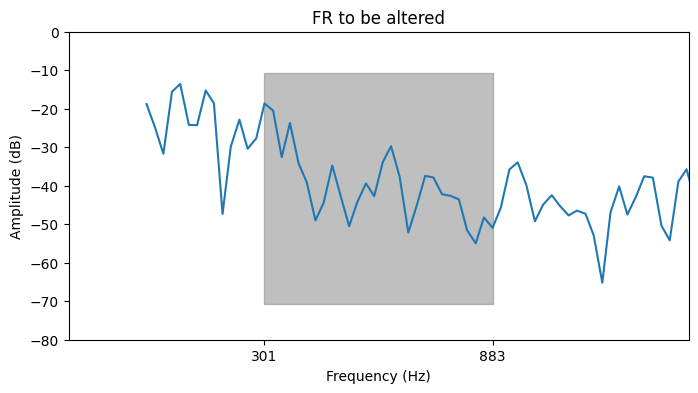

In [129]:
# Define frequency range for further augmentations

low_freq = 300
high_freq = 900
print(f'Filtering from {low_freq} to {high_freq}')
freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

# Plot FR
redhot_db = fourier_db(stft)
gray_area_x = [fft_freqs[freq_bins[0]], fft_freqs[freq_bins[-1]]]
plot_fourier(signal=redhot_db, fft_freqs=fft_freqs, title='FR to be altered', fill_area=gray_area_x, fill=True)


In [130]:
# add noise within the FR

noise_level_dB = 0.05  # Noise level in dB
low_freq = 300
high_freq = 900
audio_noise = noise_in_freq_range(stft, low_freq, high_freq, noise_level_dB, band_pass=True)

# Save the modified audio to a new file
sf.write('output_noisy.wav', audio_noise, sr)
ipd.Audio(audio_noise, rate=sr)

# plot_compare(redhot_file, audio_noise)


In [150]:
# MixUp augmentation technique according to Inoue(2018)

# Define FR to be patched
low_freq = 500
high_freq = 1000
noise_level_dB = 3
freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

# Extract audio patch from another file
patch = fr'C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\duke.wav'
# patch = fr'C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\Pop_voice.wav'
title2 = patch.split('''\\''')[-1]

# Load the patch file
patch_file, sr = librosa.load(patch)#, mono=mono, sr=sr)
patch_stft = librosa.stft(patch_file)
print(patch_stft.shape)

# TODO: Check the case len(patch) < len(audio) in mixup.
mix_up_audio = mix_up(signal=redhot, patch=patch,low_freq=low_freq, high_freq=high_freq, noise_level_dB=noise_level_dB)
# 
# # Save new audio
sf.write('mix_up_audio.wav', mix_up_audio, sr)
ipd.Audio(mix_up_audio, rate=sr)

# plot_mel_spectrogam(audio_noise, title2)

(1025, 1292)


ValueError: could not broadcast input array from shape (20,1292) into shape (20,431)

<Figure size 800x400 with 0 Axes>

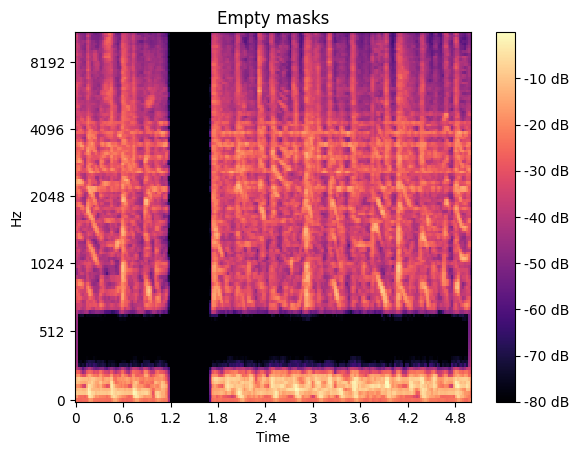

In [151]:
# SpecAugment without Mel Filter banks - only applying freq and temp masks
# create masks

# TODO: Set a limit for duration of both audio and mask.
freq_mask = np.zeros_like(a=stft[10:30])
time_mask = np.zeros_like(a=stft.T[100:150])

stft[10:30] = freq_mask
stft.T[100:150] = time_mask
tryout = librosa.istft(stft)
plot_mel_spectrogam(tryout, 'Empty masks')

patch_freq_mask = patch_stft[10:30]
patch_time_mask = patch_stft.T[100:150]

stft[10:30] = patch_freq_mask
stft.T[100:150] = patch_time_mask
patch_tryout = librosa.istft(stft)
plot_mel_spectrogam(patch_tryout, 'Patch masks')

In [150]:
# Save new audio
# output_filename = 'tryout.wav'
sf.write('empty_mask.wav', tryout, sr)
ipd.Audio(tryout, rate=sr)

In [151]:
# Save new audio
sf.write('patch_mask.wav', patch_tryout, sr)
ipd.Audio(patch_tryout, rate=sr)

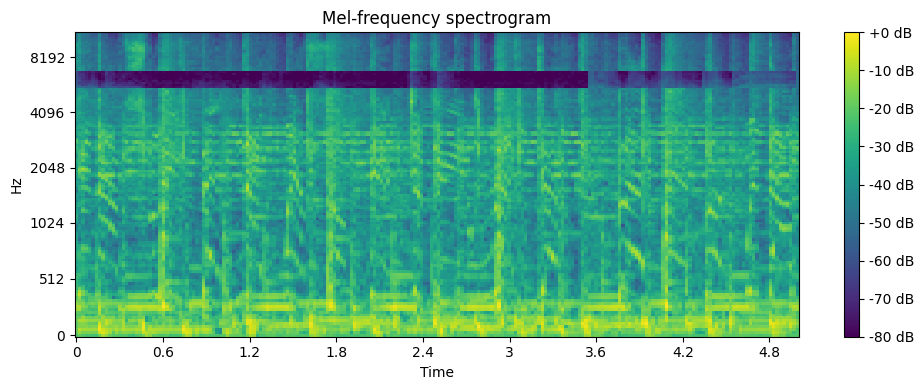

In [7]:
# def spec_augment(mask)
n_mels = 128
S = librosa.feature.melspectrogram(y=redhot_file, sr=sr, n_mels=n_mels, n_fft=1024)#,
patch_mel = librosa.feature.melspectrogram(y=patch_file, sr=sr, n_mels=n_mels, n_fft=1024)#,
# print(S.shape)
                
width = 10
mask_width = random.randint(0, width)
starting_freq = random.randint(0, n_mels - mask_width)
S[starting_freq:starting_freq+mask_width] = patch_mel[starting_freq:starting_freq+mask_width]
# print(starting_freq, mask_width)
# print(S.shape)

# Plot the mel spectrogram
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [112]:
# Convert the decibels back to power using a reference value
ref_power = np.max(S)
S_reconstructed = librosa.db_to_power(S_dB, ref=ref_power)

# Convert the mel spectrogram back to linear frequency spectrogram
mel_basis = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=128, fmax=8000)
S_inv = np.dot(np.linalg.pinv(mel_basis), S_reconstructed)

# Perform the inverse STFT
s_tryout = librosa.istft(S_inv)

# s_tryout = librosa.istft(S)
# Save new audio
# output_filename = 's_tryout.wav'
sf.write('s_tryout.wav', s_tryout, sr)
ipd.Audio(s_tryout, rate=sr)

In [11]:
mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
mag_mask, phase_mask = librosa.magphase(patch_stft)
mel_mask = np.dot(mel_filters, mag_mask)

mag_audio, phase_audio = librosa.magphase(stft)
mel_audio = np.dot(mel_filters, mag_audio)

# print(mel_mask.shape, mel_audio.shape)

# Apply patch
mel_filter_idx = 10
noise_level_dB = 3
noise_level_linear = 10**(noise_level_dB / 20.0)
mel_mask[mel_filter_idx] *= noise_level_linear
mel_audio[mel_filter_idx] = mel_mask[mel_filter_idx]

# plt.figure(figsize=(8,6))
# plt.plot(mel_mask[mel_filter_idx], c='blue')
# plt.plot(mel_audio[mel_filter_idx], c='green')
# plt.yscale('log')
# plt.show()
# plt.close()

# Convert the modified mel-scaled representation back to the time domain
audio_modified = librosa.feature.inverse.mel_to_audio(mel_audio, sr=sr, n_fft=1024)
print(audio_modified.shape)
# sf.write('audio_modified.wav', audio_modified, sr)
# ipd.Audio(audio_modified, rate=sr)
# spec_aug_audio = new_mag_audio * phase_audio
# 
# stft_mag_orig_to_mel[10] = patch_stft_to_mel[10]
# mag_orig_mod = librosa.mel_to_hz(stft_mag_orig_to_mel)
# print(stft_mag_orig_mod.shape)
# augmented_original = stft_mag_orig_mod * stft_phase_orig
# aug_original_audio = librosa.istft(augmented_original)


# patch_freq = librosa.mel_to_hz(patch_stft_to_mel)

# 
# print(patch_freq.shape, stft_mag_patch.shape)
# 
# modified_patch = stft_mag_patch * stft_phase_patch
# modified_patch_audio = librosa.istft(modified_patch)
# plot_mel_spectrogam(aug_original_audio, 'Original patch')
# plot_mel_spectrogam(modified_patch_audio, 'Modified patch')

# print(modified_patch == patch_stft)

# output_filename = 's_tryout.wav'
# sf.write('modified_patch_audio.wav', modified_patch_audio, sr)
# ipd.Audio(modified_patch_audio, rate=sr)


(110080,)


Filter 0: 0.00 Hz
Filter 1: 15.46 Hz
Filter 2: 31.27 Hz
Filter 3: 47.42 Hz
Filter 4: 63.93 Hz
Filter 5: 80.80 Hz
Filter 6: 98.05 Hz
Filter 7: 115.68 Hz
Filter 8: 133.69 Hz
Filter 9: 152.11 Hz
Filter 10: 170.93 Hz
Filter 11: 190.17 Hz
Filter 12: 209.83 Hz
Filter 13: 229.93 Hz
Filter 14: 250.47 Hz
Filter 15: 271.46 Hz
Filter 16: 292.92 Hz
Filter 17: 314.85 Hz
Filter 18: 337.27 Hz
Filter 19: 360.18 Hz
Filter 20: 383.60 Hz
Filter 21: 407.53 Hz
Filter 22: 432.00 Hz
Filter 23: 457.00 Hz
Filter 24: 482.56 Hz
Filter 25: 508.68 Hz
Filter 26: 535.37 Hz
Filter 27: 562.66 Hz
Filter 28: 590.55 Hz
Filter 29: 619.06 Hz
Filter 30: 648.19 Hz
Filter 31: 677.97 Hz
Filter 32: 708.41 Hz
Filter 33: 739.52 Hz
Filter 34: 771.32 Hz
Filter 35: 803.82 Hz
Filter 36: 837.03 Hz
Filter 37: 870.99 Hz
Filter 38: 905.69 Hz
Filter 39: 941.15 Hz
Filter 40: 977.40 Hz
Filter 41: 1014.45 Hz
Filter 42: 1052.32 Hz
Filter 43: 1091.03 Hz
Filter 44: 1130.59 Hz
Filter 45: 1171.03 Hz
Filter 46: 1212.35 Hz
Filter 47: 1254.60 Hz
Fil

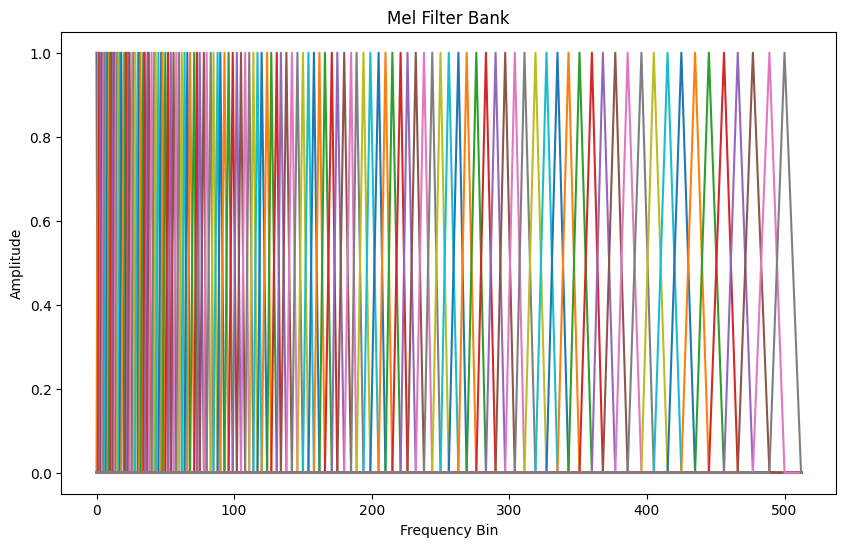

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import get_window
from scipy.fftpack import dct

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595.0) - 1)

def get_mel_filter_bank(sr, n_fft, n_mels):
    low_freq_mel = 0
    high_freq_mel = hz_to_mel(sr / 2)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    fbank = np.zeros((n_mels, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, n_mels + 1):
        f_m_minus = bin_points[m - 1]   # left
        f_m = bin_points[m]             # center
        f_m_plus = bin_points[m + 1]    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - f_m_minus) / (f_m - f_m_minus)
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (f_m_plus - k) / (f_m_plus - f_m)

    return fbank, hz_points

# Parameters
sr = 22050       # Sample rate
n_fft = 1024     # FFT size
n_mels = 128     # Number of mel filters

# Compute the mel filter bank
mel_filters, hz_points = get_mel_filter_bank(sr, n_fft, n_mels)

# Print the frequencies corresponding to each filter
for i, hz in enumerate(hz_points):
    print(f"Filter {i}: {hz:.2f} Hz")

# Visualize the mel filter bank
plt.figure(figsize=(10, 6))
for i in range(n_mels):
    plt.plot(mel_filters[i])
plt.title('Mel Filter Bank')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.show()
